In [1]:
%%capture
! pip install xclim

In [2]:
import xclim.sdba

In [3]:
import xesmf
import xarray as xr
import numpy as np
from science_validation_manual import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rhg_compute_tools.kubernetes as rhgk

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
client, cluster = rhgk.get_micro_cluster()

In [90]:
cluster.scale(200)
cluster

In [97]:
client.restart()
client.close()
cluster.close()

In [92]:
# ERA-5 data

ds_era_5 = read_gcs_zarr('gs://clean-b1dbca25/reanalysis/ERA-5/F320/tasmin.1995-2015.F320.zarr')['tasmin'].chunk(dict(time=-1))

# NESM3 data -- ssp245 for future
# ds_historical_clean_sim_gcm = read_gcs_zarr('gs://scratch-170cd6ec/080c199e-1208-4068-911e-98bd5d2b59ab/e2e-nesm3-tasmin-656ln-3232100922/rechunked.zarr')['tasmin'].chunk(dict(time=-1))
# ds_historical_bs_gcm = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/NUIST/NESM3/historical/r1i1p1f1/day/tasmin/gn/v20220114235347.zarr')['tasmin'].chunk(dict(time=-1))
# ds_future_clean_sim_gcm = read_gcs_zarr('gs://scratch-170cd6ec/080c199e-1208-4068-911e-98bd5d2b59ab/e2e-nesm3-tasmin-656ln-1526085477/rechunked.zarr')['tasmin'].chunk(dict(time=-1))
# ds_future_bs_gcm = read_gcs_zarr('gs://biascorrected-492e989a/stage/ScenarioMIP/NUIST/NESM3/ssp245/r1i1p1f1/day/tasmin/gn/v20220114235347.zarr')['tasmin'].chunk(dict(time=-1))
# ds_future_dsc_gcm = read_gcs_zarr('gs://downscaled-288ec5ac/stage/ScenarioMIP/NUIST/NESM3/ssp245/r1i1p1f1/day/tasmin/gn/v20220114235347.zarr')['tasmin'].chunk(dict(time=-1))

# MIROC-6 data -- ssp370 for future

ds_historical_clean_training_gcm = read_gcs_zarr('gs://scratch-170cd6ec/0d195a70-195e-471b-a2d2-374e00fe7dd3/e2e-miroc6-tasmin-rx8vz-1637415345/rechunked.zarr')['tasmin'].chunk(dict(time=-1))
ds_historical_clean_sim_gcm = read_gcs_zarr('gs://scratch-170cd6ec/0d195a70-195e-471b-a2d2-374e00fe7dd3/e2e-miroc6-tasmin-rx8vz-4163102812/rechunked.zarr')['tasmin'].chunk(dict(time=-1))
ds_historical_bs_gcm = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/MIROC/MIROC6/historical/r1i1p1f1/day/tasmin/gn/v20220114235345.zarr')['tasmin'].chunk(dict(time=-1))
ds_future_clean_sim_gcm = read_gcs_zarr('gs://scratch-170cd6ec/0d195a70-195e-471b-a2d2-374e00fe7dd3/e2e-miroc6-tasmin-rx8vz-1725314735/rechunked.zarr')['tasmin'].chunk(dict(time=-1))
ds_future_bs_gcm = read_gcs_zarr('gs://biascorrected-492e989a/stage/ScenarioMIP/MIROC/MIROC6/ssp370/r1i1p1f1/day/tasmin/gn/v20220114235345.zarr')['tasmin'].chunk(dict(time=-1))
ds_future_dsc_gcm = read_gcs_zarr('gs://downscaled-288ec5ac/stage/ScenarioMIP/MIROC/MIROC6/ssp370/r1i1p1f1/day/tasmin/gn/v20220114235345.zarr')['tasmin'].chunk(dict(time=-1))

In [93]:
qtles = [0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1]
#qtles = [0.1, 0.9]

## Trends in quantiles preserved ? Comparing GCM trends pre and post bias correction 

In [94]:
trend_raw = ds_future_clean_sim_gcm.quantile(q=qtles, dim='time')-ds_historical_clean_sim_gcm.quantile(q=qtles, dim='time')
trend_bs = ds_future_bs_gcm.quantile(q=qtles, dim='time')-ds_historical_bs_gcm.quantile(q=qtles, dim='time')

In [95]:
data_dict = {
    'trend (clean)': trend_raw,
    'trend (biascorrected)': trend_bs
}

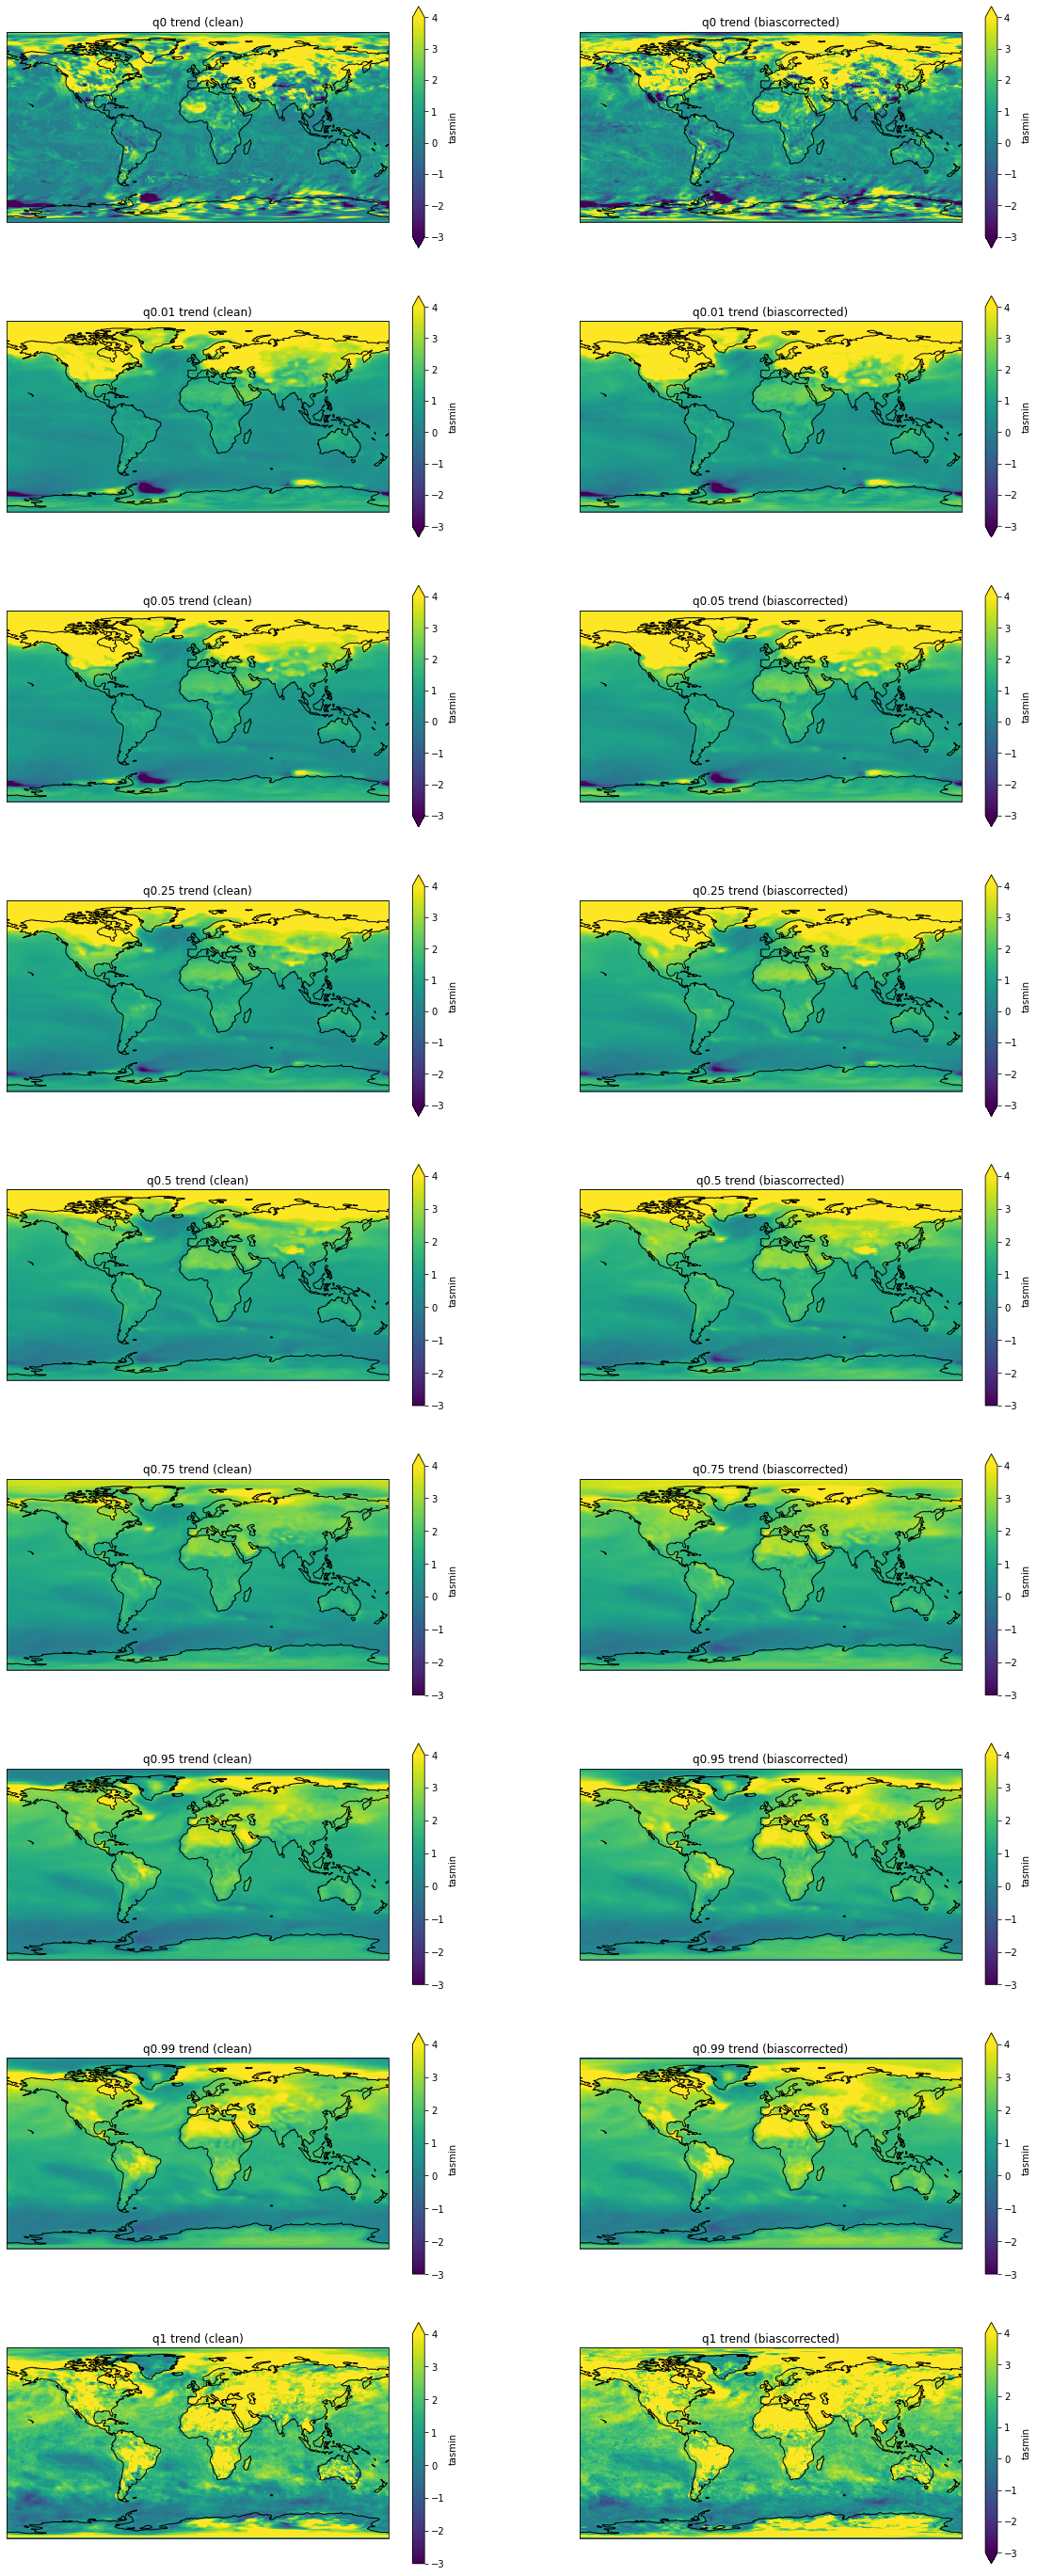

In [96]:
fig, axes = plt.subplots(len(qtles), 2, figsize=(20, 50),subplot_kw={'projection': ccrs.PlateCarree()})
i = 0 
for q in qtles:
    j = 0
    for key, da in data_dict.items():
        da.sel(quantile=q, drop=True).plot.pcolormesh(ax=axes[i,j], vmin=-3, vmax=4)
        axes[i,j].coastlines()
        axes[i,j].set_title(f'q{q} {key}')
        j = j + 1 
    i = i + 1